In [1]:
## Load modules

# Standard modules
import pandas as pd
import numpy as np

# Preprocessing modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,\
 OneHotEncoder, LabelEncoder, OrdinalEncoder

# Train-test split module
from sklearn.model_selection import train_test_split

# Classifier modules
from sklearn.ensemble import RandomForestClassifier

# Regression modules
from sklearn.ensemble import RandomForestRegressor

# Model selection modules
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

# Pipeline module
from sklearn.pipeline import Pipeline

# Imputation modules
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

# Performance metric modules
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 4.0) # set default size of plots

pd.options.display.max_columns = None

# Module for categorical variables
from pandas.api.types import CategoricalDtype

# Modules for building custom encoders and transformers
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
DATA_DIR = 'Data/'

In [4]:
## Load ICU Data
file = DATA_DIR+'ICU_filtered.csv'
dfICU = pd.read_csv(file, sep = ',', header = 0, index_col = 0)

print('ICU dataset')
print('-----------')
print('Initial number of samples = %d'%(dfICU.shape[0]))
print('Initial number of features = %d\n'%(dfICU.shape[1]))
dfICU.head(5)

ICU dataset
-----------
Initial number of samples = 7886
Initial number of features = 35



,Length_of_stay,In-hospital_death,Age,Gender,Height,CCU,CSRU,SICU,DiasABP_first,GCS_first,Glucose_first,HR_first,MAP_first,NIDiasABP_first,NIMAP_first,NISysABP_first,Temp_first,BUN_first,Creatinine_first,FiO2_first,HCO3_first,HCT_first,K_first,Lactate_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,SysABP_first,WBC_first,Weight,pH_first,MechVent,UrineOutputSum
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132539,5,0,54,0.0,NaN,0,0,1,NaN,15.0,205.0,73.0,NaN,65.0,92.33,147.0,35.1,13.0,0.8,NaN,26.0,33.7,4.4,NaN,1.5,137.0,NaN,NaN,221.0,NaN,11.2,NaN,NaN,0,NaN
132540,8,0,76,1.0,175.3,0,1,0,67.0,3.0,105.0,88.0,79.0,38.0,49.33,72.0,35.2,16.0,0.8,1.0,21.0,24.7,4.3,NaN,3.1,139.0,34.0,344.0,164.0,105.0,7.4,80.6,7.45,1,5.0
132541,19,0,44,0.0,NaN,0,0,0,81.0,7.0,141.0,100.0,107.0,84.0,100.30,133.0,37.8,8.0,0.4,1.0,24.0,28.5,3.3,1.3,1.9,137.0,37.0,65.0,72.0,148.0,4.2,56.7,7.51,1,14.0
132543,9,0,68,1.0,180.3,0,0,0,NaN,15.0,129.0,79.0,NaN,63.0,86.67,134.0,36.3,23.0,0.9,NaN,28.0,41.3,4.0,NaN,2.1,140.0,NaN,NaN,391.0,NaN,11.5,84.6,NaN,0,NaN
132545,4,0,88,0.0,NaN,0,0,0,NaN,15.0,113.0,93.0,NaN,41.0,75.33,144.0,37.8,45.0,1.0,NaN,18.0,22.6,6.0,NaN,1.5,140.0,NaN,NaN,109.0,NaN,3.8,NaN,NaN,0,NaN


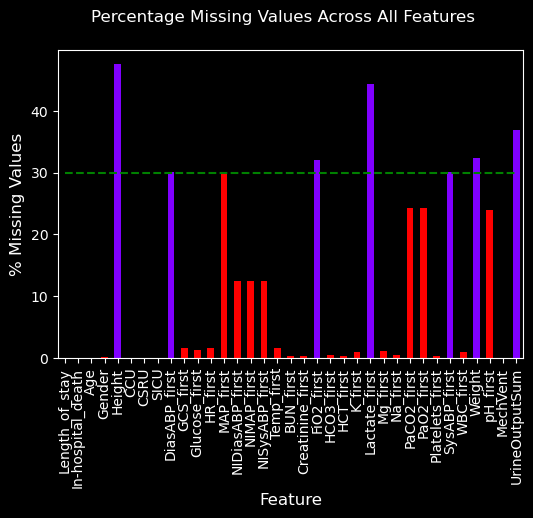

In [5]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30 # we will remove features missing in more than 20% of the samples
fig = plt.figure(figsize=(6, 4))
percent_missing = (dfICU.isna().sum() / dfICU.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(dfICU.shape[1]), np.repeat(cutoff, dfICU.shape[1]), 'g--')
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 12)
plt.xlabel('Feature', fontsize = 12)
plt.ylabel('% Missing Values', fontsize = 12);

In [6]:
## Wrangle the dataframe
# Retain features with <= cutoff percentage missing values
dfICU = dfICU.loc[:, dfICU.columns[percent_missing <= cutoff]]

# Collate different one-hot-encoded ICU-type columns into a single column called ICU
dfICU.loc[dfICU['CCU'] == 1, 'ICU'] = 1
dfICU.loc[dfICU['CSRU'] == 1, 'ICU'] = 2
dfICU.loc[dfICU['SICU'] == 1, 'ICU'] = 3
dfICU.loc[(dfICU['CCU'] == 0 ) & (dfICU['CSRU'] == 0) & (dfICU['SICU'] == 0), 'ICU'] = 4
dfICU.drop(['CCU', 'CSRU', 'SICU'], axis = 1, inplace = True)

In [7]:
# Create lists of ordinal, categorical, and continuous features
ordinal_features = ['GCS_first']
categorical_features = [ 'Gender', 'ICU', 'MechVent']
continuous_features = dfICU.columns[~dfICU.columns.isin(ordinal_features + categorical_features)].to_list()
dfICU.head(5)

,Length_of_stay,In-hospital_death,Age,Gender,GCS_first,Glucose_first,HR_first,MAP_first,NIDiasABP_first,NIMAP_first,NISysABP_first,Temp_first,BUN_first,Creatinine_first,HCO3_first,HCT_first,K_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,WBC_first,pH_first,MechVent,ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,
132539,5,0,54,0.0,15.0,205.0,73.0,NaN,65.0,92.33,147.0,35.1,13.0,0.8,26.0,33.7,4.4,1.5,137.0,NaN,NaN,221.0,11.2,NaN,0,3.0
132540,8,0,76,1.0,3.0,105.0,88.0,79.0,38.0,49.33,72.0,35.2,16.0,0.8,21.0,24.7,4.3,3.1,139.0,34.0,344.0,164.0,7.4,7.45,1,2.0
132541,19,0,44,0.0,7.0,141.0,100.0,107.0,84.0,100.30,133.0,37.8,8.0,0.4,24.0,28.5,3.3,1.9,137.0,37.0,65.0,72.0,4.2,7.51,1,4.0
132543,9,0,68,1.0,15.0,129.0,79.0,NaN,63.0,86.67,134.0,36.3,23.0,0.9,28.0,41.3,4.0,2.1,140.0,NaN,NaN,391.0,11.5,NaN,0,4.0
132545,4,0,88,0.0,15.0,113.0,93.0,NaN,41.0,75.33,144.0,37.8,45.0,1.0,18.0,22.6,6.0,1.5,140.0,NaN,NaN,109.0,3.8,NaN,0,4.0


In [8]:
## Custom ordinal encoder
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_cols_dict: dict):
        self.ordinal_cols_dict = ordinal_cols_dict

    def fit(self, X: pd.DataFrame, y = None):
        return self

    def transform(self, X: pd.DataFrame, y = None):
        for col, order in self.ordinal_cols_dict.items():
            cat_type = CategoricalDtype(categories = self.ordinal_cols_dict[col], ordered = True)
            X[col] = X[col].astype(cat_type).factorize(sort = True)[0]
            X[col] = X[col].astype(CategoricalDtype(ordered = True))
            X[col] = X[col].replace(-1, np.nan)
        return X

    def fit_transform(self, X: pd.DataFrame, y = None):
        self.fit(X)
        return self.transform(X)

In [9]:
## Custom categorical encoder
class CustomCategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols: list):
        self.categorical_cols = categorical_cols

    def fit(self, X: pd.DataFrame, y = None):
        return self

    def transform(self, X: pd.DataFrame, y = None):
        for col in self.categorical_cols:
            cat_type = 'category'
            X[col] = X[col].astype(cat_type).factorize()[0]
            X[col] = X[col].astype('category')
            X[col] = X[col].replace(-1, np.nan)
        return X

    def fit_transform(self, X: pd.DataFrame, y = None):
        self.fit(X)
        return self.transform(X)

In [11]:
## Build preprocessing pipeline for ordinal, categorical, and continuous features
# Define preprocessing pipeline for ordinal features
# Dictionary for ordinal features
ordinal_cols_dict = {
    'GCS_first': np.arange(np.max(dfICU['GCS_first']), np.min(dfICU['GCS_first'])-1, -1)
    }
ordinal_transformer = Pipeline(steps = [('customordenc', CustomOrdinalEncoder(ordinal_cols_dict)),
    ('imputer', IterativeImputer(estimator = RandomForestClassifier(n_estimators = 3),
                                 initial_strategy = 'most_frequent',
                                 missing_values = np.nan,
                                 max_iter = 10,
                                 random_state = 0))])


In [12]:

# Define preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps = [('customcatenc', CustomCategoricalEncoder(categorical_features)),
    ('imputer', IterativeImputer(estimator = RandomForestClassifier(n_estimators = 3),
                                 initial_strategy = 'most_frequent',
                                 missing_values = np.nan,
                                 max_iter = 10,
                                 random_state = 0))])


In [13]:

# Define preprocessing pipeline for continuous features
numeric_transformer = Pipeline(steps = [('imputer', IterativeImputer(estimator = RandomForestRegressor(n_estimators = 3),
                                                                     initial_strategy = 'median',
                                                                     missing_values = np.nan,
                                                                     max_iter = 10,
                                                                     random_state = 0)),
                                        ('scaler', RobustScaler())])


In [14]:

# Create preprocessor object for all features
preprocessor = ColumnTransformer(transformers = [('ord', ordinal_transformer, ordinal_features),
                                                 ('cat', categorical_transformer, categorical_features),
                                                 ('num', numeric_transformer, continuous_features)
                                                 ])


In [16]:

class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_cols_dict: dict, continuous_cols: list):
        self.ordinal_cols_dict = ordinal_cols_dict
        self.continuous_cols = continuous_cols

    def fit(self, X: pd.DataFrame, y = None):
        return self

    def transform(self, X: pd.DataFrame, y = None):
        for col, order in self.ordinal_cols_dict.items():
            cat_type = CategoricalDtype(categories = self.ordinal_cols_dict[col], ordered = True)
            X[col] = X[col].astype(cat_type).factorize(sort = True)[0]
            X[col] = X[col].astype(CategoricalDtype(ordered = True))
            X[col] = X[col].replace(-1, np.nan)
        
        for col in self.continuous_cols:
            X[col] = pd.cut(X[col], bins=5, labels=False)
        
        return X

    def fit_transform(self, X: pd.DataFrame, y = None):
        self.fit(X)
        return self.transform(X)


In [17]:
dfICU

,Length_of_stay,In-hospital_death,Age,Gender,GCS_first,Glucose_first,HR_first,MAP_first,NIDiasABP_first,NIMAP_first,NISysABP_first,Temp_first,BUN_first,Creatinine_first,HCO3_first,HCT_first,K_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,WBC_first,pH_first,MechVent,ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,
132539,5,0,54,0.0,15.0,205.0,73.0,NaN,65.0,92.33,147.0,35.1,13.0,0.8,26.0,33.7,4.4,1.5,137.0,NaN,NaN,221.0,11.2,NaN,0,3.0
132540,8,0,76,1.0,3.0,105.0,88.0,79.0,38.0,49.33,72.0,35.2,16.0,0.8,21.0,24.7,4.3,3.1,139.0,34.0,344.0,164.0,7.4,7.45,1,2.0
132541,19,0,44,0.0,7.0,141.0,100.0,107.0,84.0,100.30,133.0,37.8,8.0,0.4,24.0,28.5,3.3,1.9,137.0,37.0,65.0,72.0,4.2,7.51,1,4.0
132543,9,0,68,1.0,15.0,129.0,79.0,NaN,63.0,86.67,134.0,36.3,23.0,0.9,28.0,41.3,4.0,2.1,140.0,NaN,NaN,391.0,11.5,NaN,0,4.0
132545,4,0,88,0.0,15.0,113.0,93.0,NaN,41.0,75.33,144.0,37.8,45.0,1.0,18.0,22.6,6.0,1.5,140.0,NaN,NaN,109.0,3.8,NaN,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152849,6,0,78,1.0,3.0,110.0,110.0,77.0,51.0,79.33,136.0,36.8,25.0,0.9,23.0,33.0,5.2,2.9,136.0,35.0,374.0,103.0,20.0,7.43,1,2.0
152851,10,0,90,1.0,13.0,120.0,97.0,72.0,32.0,50.33,87.0,37.2,49.0,2.3,11.0,34.2,3.0,1.4,141.0,31.0,69.0,332.0,27.4,7.13,1,4.0
152858,19,0,70,0.0,14.0,103.0,65.0,86.0,68.0,94.67,148.0,37.3,28.0,1.5,14.0,32.1,4.2,1.9,141.0,30.0,108.0,227.0,14.8,7.35,0,2.0


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


In [33]:

# Load and preprocess the dataset
X = dfICU.drop(['In-hospital_death', 'Length_of_stay'], axis=1)
y = dfICU[['In-hospital_death', 'Length_of_stay']]


In [34]:

# Load and preprocess the dataset
X = dfICU.drop(['In-hospital_death', 'Length_of_stay'], axis=1)
y = dfICU[['In-hospital_death', 'Length_of_stay']]


In [35]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# Define the preprocessing steps
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


In [36]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [37]:
#Define the model architecture
def create_model():
    # Define the input layer
    input_layer = Input(shape=(X_train.shape[1],))

    # Define the hidden layers
    hidden_layer_1 = Dense(32, activation='relu')(input_layer)
    hidden_layer_2 = Dense(16, activation='relu')(hidden_layer_1)

    # Define the output layers
    output_layer_1 = Dense(1, activation='sigmoid', name='survived')(hidden_layer_2)
    output_layer_2 = Dense(1, name='length_of_stay')(hidden_layer_2)

    # Create the model
    model = Model(inputs=input_layer, outputs=[output_layer_1, output_layer_2])

    # Compile the model
    model.compile(loss={'survived': 'binary_crossentropy', 'length_of_stay': 'mse'},
                  optimizer='adam')

    return model


In [38]:
from keras.wrappers.scikit_learn import KerasRegressor
# Integrate the model with the pipeline
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])


C:\Users\adity\AppData\Local\Temp\ipykernel_12132\3491214743.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


In [89]:
# Define the input layer
input_layer = Input(shape=(X_train.shape[1],))

# Define the hidden layers
hidden_layer_1 = Dense(32, activation='relu')(input_layer)
hidden_layer_2 = Dense(16, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(8, activation='relu')(hidden_layer_2)

# Define the output layers
output_layer_1 = Dense(1, activation='sigmoid', name='In-hospital_death')(hidden_layer_2)
output_layer_2 = Dense(1, name='Length_of_stay')(hidden_layer_2)
output_layer_3 = Dense(1, name='Length_of_stay')(hidden_layer_3)

# Define two separate target variables for each output layer
y_train_survived = y_train['In-hospital_death']
y_train_length_of_stay = y_train['Length_of_stay']

# Convert y_train to list of arrays
y_train_list = [y_train['In-hospital_death'].values, y_train['Length_of_stay'].values]


In [90]:

# Fit the model with list of target variables
pipeline.fit(X_train, y_train_list, model__validation_split=0.2)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x000002AD59D972D0>)])

In [91]:
# Fit the model with separate target variables
pipeline.fit(X_train, {'In-hospital_death': y_train_survived, 'Length_of_stay': y_train_length_of_stay}, model__validation_split=0.2)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x000002AD59D972D0>)])

In [95]:
# Predict the target variables
y_pred_survived, y_pred_length_of_stay = pipeline.predict(X_test)


In [108]:
# Evaluate the model
pipeline.score(X_test, {'In-hospital_death': y_test['In-hospital_death'], 'Length_of_stay': y_test['Length_of_stay']})

# print the model score
print('Model Score: %.2f' % pipeline.score(X_test, {'In-hospital_death': y_test['In-hospital_death'], 'Length_of_stay': y_test['Length_of_stay']}))


Model Score: nan


In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_death, y_pred_length = y_pred[0], y_pred[1]
y_test_death, y_test_length = y_test['In-hospital_death'].values, y_test['Length_of_stay'].values


In [105]:
y_pred_death = pd.Series(y_pred_death).fillna(0).values
y_pred_length = pd.Series(y_pred_length).fillna(0).values


In [106]:
print("Accuracy for predicting survival:", accuracy_score(y_test_death, y_pred_death > 0.5))


Accuracy for predicting survival: 0.8548795944233206


In [107]:
print("MSE for predicting length of stay:", mean_squared_error(y_test_length, y_pred_length))

MSE for predicting length of stay: 323.3377693282636
